# CCC3 - Combined Collaborative Approach (Multi-Task Learning)

## Strategy
- **Multi-Task Learning**: Single model learns both tasks simultaneously
  - Task 1: Connection prediction (Binary Classification)
  - Task 2: Rating prediction (Regression)
  - Shared LightGCN embeddings benefit both tasks
- **Hybrid Loss**: λ₁ * BPR_loss + λ₂ * MSE_loss
- **Dual Prediction**: Outputs both connection probability and rating value

## Key Features:
- ✅ End-to-end joint training
- ✅ Shared representation learning
- ✅ Two prediction heads from same embedding
- ✅ Multi-task loss balancing

## Architecture:
```
LightGCN (shared)
    ↓
User & Item Embeddings
    ↓
    ├─→ Connection Head → P(connection)
    └─→ Rating Head → predicted_rating
```

## Hyperparameters:
- `EMB_DIM`: 32
- `N_LAYERS`: 2
- `LAMBDA_CONN`: 1.0 (weight for BPR loss)
- `LAMBDA_RATING`: 0.5 (weight for MSE loss)
- `CONN_THRESHOLD`: 0.5 (connection probability threshold)
- `RATING_THRESHOLD`: 4.0 (rating quality threshold)

## Expected Performance:
- Better than CCC1/CCC2: Joint learning improves both tasks
- More efficient: Single model instead of two
- AUC-ROC target: 0.94+
- F1 target: 0.88+

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Device: {device} ({torch.cuda.get_device_name()})')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f'Device: {device}')
else:
    device = torch.device('cpu')
    print(f'Device: {device}')

Device: mps


## 1. Data Preprocessing

In [2]:
df = pd.read_csv('../data/train.csv')

print(f"Total interactions: {len(df):,}")
print(f"Unique users: {df['user'].nunique()}")
print(f"Unique items: {df['item'].nunique()}")

GOOD_RATING_THRESHOLD = 4.0
n_good_purchases = (df['rating'] >= GOOD_RATING_THRESHOLD).sum()
print(f"\nGood purchases (rating >= {GOOD_RATING_THRESHOLD}): {n_good_purchases:,} ({100*n_good_purchases/len(df):.1f}%)")

user2idx = {u: i for i, u in enumerate(sorted(df['user'].unique()))}
item2idx = {it: i for i, it in enumerate(sorted(df['item'].unique()))}
idx2user = {i: u for u, i in user2idx.items()}
idx2item = {i: it for it, i in item2idx.items()}

n_users, n_items = len(user2idx), len(item2idx)

df['user_idx'] = df['user'].map(user2idx)
df['item_idx'] = df['item'].map(item2idx)

print(f"\nUsers: {n_users}, Items: {n_items}")

Total interactions: 105,139
Unique users: 668
Unique items: 10321

Good purchases (rating >= 4.0): 51,830 (49.3%)

Users: 668, Items: 10321


In [3]:
# Train/Val/Test Split
train_data, val_data, test_data = [], [], []

for user_idx in range(n_users):
    user_df = df[df['user_idx'] == user_idx]
    
    good_purchases = user_df[user_df['rating'] >= GOOD_RATING_THRESHOLD][['user_idx', 'item_idx', 'rating']]
    bad_purchases = user_df[user_df['rating'] < GOOD_RATING_THRESHOLD][['user_idx', 'item_idx', 'rating']]
    
    if len(bad_purchases) > 0:
        train_data.append(bad_purchases[['user_idx', 'item_idx']])
    
    n_good = len(good_purchases)
    
    if n_good >= 3:
        good_purchases = good_purchases.sample(frac=1, random_state=SEED).reset_index(drop=True)
        train_end = int(0.7 * n_good)
        val_end = train_end + int(0.15 * n_good)
        
        train_end = max(1, train_end)
        val_end = max(train_end + 1, val_end)
        
        train_data.append(good_purchases.iloc[:train_end][['user_idx', 'item_idx']])
        val_data.append(good_purchases.iloc[train_end:val_end][['user_idx', 'item_idx']])
        test_data.append(good_purchases.iloc[val_end:][['user_idx', 'item_idx']])
    elif n_good == 2:
        good_purchases = good_purchases.sample(frac=1, random_state=SEED).reset_index(drop=True)
        train_data.append(good_purchases.iloc[:1][['user_idx', 'item_idx']])
        val_data.append(good_purchases.iloc[1:][['user_idx', 'item_idx']])
    elif n_good == 1:
        train_data.append(good_purchases[['user_idx', 'item_idx']])

train_df = pd.concat(train_data, ignore_index=True)
val_df = pd.concat(val_data, ignore_index=True) if val_data else pd.DataFrame(columns=['user_idx', 'item_idx'])
test_df = pd.concat(test_data, ignore_index=True) if test_data else pd.DataFrame(columns=['user_idx', 'item_idx'])

print(f"Train: {len(train_df):,}")
print(f"Val: {len(val_df):,}")
print(f"Test: {len(test_df):,}")

Train: 89,294
Val: 7,480
Test: 8,365


In [4]:
# Prepare training data with ratings
train_users = torch.LongTensor(train_df['user_idx'].values)
train_items = torch.LongTensor(train_df['item_idx'].values)

# Get ratings for training
train_ratings = []
for u, i in zip(train_df['user_idx'].values, train_df['item_idx'].values):
    rating = df[(df['user_idx'] == u) & (df['item_idx'] == i)]['rating'].values
    train_ratings.append(rating[0] if len(rating) > 0 else 3.0)
train_ratings = torch.FloatTensor(train_ratings)

user_train_items = defaultdict(set)
for u, i in zip(train_df['user_idx'].values, train_df['item_idx'].values):
    user_train_items[int(u)].add(int(i))

print(f"Training data ready: {len(train_users):,} edges")
print(f"Rating stats: mean={train_ratings.mean():.2f}, std={train_ratings.std():.2f}")

Training data ready: 89,294 edges
Rating stats: mean=3.37, std=1.05


## 2. Multi-Task Model Definition

### LightGCN with Dual Heads:

In [5]:
class LightGCN_MultiTask(nn.Module):
    """
    ★ CCC3: Multi-Task LightGCN
    
    Shared LightGCN backbone with two prediction heads:
    1. Connection Head: Predicts connection probability
    2. Rating Head: Predicts rating value (0.5 ~ 5.0)
    """
    def __init__(self, n_users, n_items, emb_dim=32, n_layers=2):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        
        # Shared embeddings
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)
        
        # Task 1: Connection prediction head
        self.connection_head = nn.Sequential(
            nn.Linear(emb_dim, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 1)
        )
        
        # Task 2: Rating prediction head
        self.rating_head = nn.Sequential(
            nn.Linear(emb_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )
    
    def forward(self, edge_index, edge_weight):
        """LightGCN propagation (shared)"""
        all_emb = torch.cat([self.user_emb.weight, self.item_emb.weight], dim=0)
        embs = [all_emb]
        
        for _ in range(self.n_layers):
            row, col = edge_index
            messages = all_emb[col] * edge_weight.unsqueeze(1)
            all_emb = torch.zeros_like(all_emb).scatter_add(
                0, row.unsqueeze(1).expand(-1, self.emb_dim), messages
            )
            embs.append(all_emb)
        
        final_emb = torch.mean(torch.stack(embs), dim=0)
        return final_emb[:self.n_users], final_emb[self.n_users:]
    
    def predict_connection(self, user_idx, item_idx, edge_index, edge_weight):
        """Task 1: Predict connection probability"""
        u_emb, i_emb = self.forward(edge_index, edge_weight)
        interaction = u_emb[user_idx] * i_emb[item_idx]
        conn_logit = self.connection_head(interaction).squeeze(-1)
        conn_prob = torch.sigmoid(conn_logit)
        return conn_prob
    
    def predict_rating(self, user_idx, item_idx, edge_index, edge_weight):
        """Task 2: Predict rating value (0.5 ~ 5.0)"""
        u_emb, i_emb = self.forward(edge_index, edge_weight)
        interaction = u_emb[user_idx] * i_emb[item_idx]
        rating_logit = self.rating_head(interaction).squeeze(-1)
        predicted_rating = torch.sigmoid(rating_logit) * 4.5 + 0.5
        return predicted_rating


print("Multi-Task model defined!")

Multi-Task model defined!


## 3. Loss Functions

In [6]:
def bpr_loss(pos_scores, neg_scores):
    """BPR Loss for connection task (ranking)"""
    diff = pos_scores.unsqueeze(1) - neg_scores
    return -torch.log(torch.sigmoid(diff) + 1e-8).mean()


def multi_task_loss(model, edge_index, edge_weight, pos_u, pos_i, pos_rating, neg_i, 
                    lambda_conn=1.0, lambda_rating=0.5):
    """
    ★ CCC3: Multi-Task Loss
    
    Combines two losses:
    1. BPR Loss: Connection ranking (pos > neg)
    2. MSE Loss: Rating value prediction
    
    Total Loss = λ_conn * BPR + λ_rating * MSE
    """
    u_emb, i_emb = model(edge_index, edge_weight)
    
    # Task 1: BPR Loss (Connection)
    pos_interaction = u_emb[pos_u] * i_emb[pos_i]
    pos_conn_logit = model.connection_head(pos_interaction).squeeze(-1)
    
    neg_interaction = u_emb[pos_u].unsqueeze(1) * i_emb[neg_i]
    neg_conn_logit = model.connection_head(neg_interaction.view(-1, model.emb_dim))
    neg_conn_logit = neg_conn_logit.view(pos_u.size(0), neg_i.size(1))
    
    loss_bpr = bpr_loss(pos_conn_logit, neg_conn_logit)
    
    # Task 2: MSE Loss (Rating)
    rating_logit = model.rating_head(pos_interaction).squeeze(-1)
    pred_rating = torch.sigmoid(rating_logit) * 4.5 + 0.5
    loss_mse = F.mse_loss(pred_rating, pos_rating)
    
    # Total Loss
    total_loss = lambda_conn * loss_bpr + lambda_rating * loss_mse
    
    return total_loss, loss_bpr.item(), loss_mse.item()


print("Loss functions defined!")

Loss functions defined!


## 4. Graph Construction

In [7]:
# Use rating-weighted graph for training
def build_rating_weighted_graph():
    users = train_df['user_idx'].values
    items = train_df['item_idx'].values
    
    ratings = []
    for u, i in zip(users, items):
        rating = df[(df['user_idx'] == u) & (df['item_idx'] == i)]['rating'].values
        ratings.append(rating[0] if len(rating) > 0 else 3)
    ratings = np.array(ratings)
    
    rating_factors = 0.4 + 0.15 * ratings
    
    edge_u2i = np.array([users, items + n_users])
    edge_i2u = np.array([items + n_users, users])
    edge_index = torch.LongTensor(np.concatenate([edge_u2i, edge_i2u], axis=1))
    
    rating_factors_both = np.concatenate([rating_factors, rating_factors])
    
    num_nodes = n_users + n_items
    deg = torch.zeros(num_nodes).scatter_add(0, edge_index[0], torch.ones(edge_index.shape[1]))
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    
    base_weight = deg_inv_sqrt[edge_index[0]] * deg_inv_sqrt[edge_index[1]]
    rating_weight = torch.FloatTensor(rating_factors_both)
    edge_weight = base_weight * rating_weight
    
    return edge_index.to(device), edge_weight.to(device)


edge_index, edge_weight = build_rating_weighted_graph()
print(f"Graph built: {edge_index.shape[1]:,} edges")

Graph built: 178,588 edges


## 5. Negative Sampling

In [8]:
def fast_sample_negatives(batch_size, num_neg=4):
    """Random negative sampling"""
    neg_items = torch.randint(0, n_items, (batch_size, num_neg))
    return neg_items


@torch.no_grad()
def hard_negative_sampling(user_emb, item_emb, pos_users, num_neg=4, num_candidates=50):
    """Hard negative mining"""
    batch_size = len(pos_users)
    
    candidates = torch.randint(0, n_items, (batch_size, num_candidates), device=device)
    
    user_expanded = user_emb[pos_users].unsqueeze(1)
    item_candidates = item_emb[candidates]
    scores = (user_expanded * item_candidates).sum(dim=2)
    
    _, top_indices = scores.topk(num_neg, dim=1)
    hard_negs = candidates.gather(1, top_indices)
    
    return hard_negs


USE_HARD_NEGATIVE = True
HARD_NEG_RATIO = 0.5

print(f"Negative sampling: Hard {HARD_NEG_RATIO:.0%} + Random {1-HARD_NEG_RATIO:.0%}")

Negative sampling: Hard 50% + Random 50%


## 6. Training Configuration

In [9]:
# Hyperparameters
EMB_DIM = 32
N_LAYERS = 2
LR = 5e-3
WEIGHT_DECAY = 1e-5
EPOCHS = 50
BATCH_SIZE = 1024
NUM_NEG = 4

# Multi-task loss weights
LAMBDA_CONN = 1.0
LAMBDA_RATING = 0.5

print(f"Training config:")
print(f"  emb_dim: {EMB_DIM}")
print(f"  n_layers: {N_LAYERS}")
print(f"  lr: {LR}")
print(f"  epochs: {EPOCHS}")
print(f"  batch_size: {BATCH_SIZE}")
print(f"  λ_conn: {LAMBDA_CONN} ★")
print(f"  λ_rating: {LAMBDA_RATING} ★")

Training config:
  emb_dim: 32
  n_layers: 2
  lr: 0.005
  epochs: 50
  batch_size: 1024
  λ_conn: 1.0 ★
  λ_rating: 0.5 ★


## 7. Training Loop

In [10]:
model = LightGCN_MultiTask(n_users, n_items, EMB_DIM, N_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

history = {
    'loss': [], 'bpr_loss': [], 'mse_loss': []
}
best_loss = float('inf')
n_train = len(train_users)

# Pre-move to device
train_u_gpu = train_users.to(device)
train_i_gpu = train_items.to(device)
train_r_gpu = train_ratings.to(device)

print(f"Training CCC3 with Multi-Task Learning...")
print("=" * 70)

start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    perm = torch.randperm(n_train, device=device)
    epoch_loss = 0
    epoch_bpr = 0
    epoch_mse = 0
    n_batches = 0
    
    for i in range(0, n_train, BATCH_SIZE):
        batch_idx = perm[i:i+BATCH_SIZE]
        pos_u = train_u_gpu[batch_idx]
        pos_i = train_i_gpu[batch_idx]
        pos_r = train_r_gpu[batch_idx]
        
        # Negative sampling
        if USE_HARD_NEGATIVE:
            with torch.no_grad():
                u_emb, i_emb = model(edge_index, edge_weight)
            
            n_hard = int(NUM_NEG * HARD_NEG_RATIO)
            n_random = NUM_NEG - n_hard
            
            if n_hard > 0:
                hard_negs = hard_negative_sampling(u_emb, i_emb, pos_u, num_neg=n_hard)
            else:
                hard_negs = None
            
            if n_random > 0:
                random_negs = fast_sample_negatives(len(batch_idx), n_random).to(device)
            else:
                random_negs = None
            
            if hard_negs is not None and random_negs is not None:
                neg_i = torch.cat([hard_negs, random_negs], dim=1)
            elif hard_negs is not None:
                neg_i = hard_negs
            else:
                neg_i = random_negs
        else:
            neg_i = fast_sample_negatives(len(batch_idx), NUM_NEG).to(device)
        
        # Multi-task loss
        loss, bpr_val, mse_val = multi_task_loss(
            model, edge_index, edge_weight,
            pos_u, pos_i, pos_r, neg_i,
            lambda_conn=LAMBDA_CONN,
            lambda_rating=LAMBDA_RATING
        )
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_bpr += bpr_val
        epoch_mse += mse_val
        n_batches += 1
    
    avg_loss = epoch_loss / n_batches
    avg_bpr = epoch_bpr / n_batches
    avg_mse = epoch_mse / n_batches
    
    history['loss'].append(avg_loss)
    history['bpr_loss'].append(avg_bpr)
    history['mse_loss'].append(avg_mse)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1:3d} | Total: {avg_loss:.4f} (BPR: {avg_bpr:.4f}, MSE: {avg_mse:.4f})")
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), '../cc_models/ccc3_best.pt')

elapsed = time.time() - start_time
print(f"\nTraining time: {elapsed/60:.1f} minutes")
print(f"Best loss: {best_loss:.4f}")

Training CCC3 with Multi-Task Learning...
Epoch   5 | Total: 0.7636 (BPR: 0.4158, MSE: 0.6956)
Epoch  10 | Total: 0.6557 (BPR: 0.3765, MSE: 0.5584)
Epoch  15 | Total: 0.6107 (BPR: 0.3623, MSE: 0.4969)
Epoch  20 | Total: 0.5768 (BPR: 0.3439, MSE: 0.4659)
Epoch  25 | Total: 0.5538 (BPR: 0.3303, MSE: 0.4469)
Epoch  30 | Total: 0.5372 (BPR: 0.3203, MSE: 0.4339)
Epoch  35 | Total: 0.5238 (BPR: 0.3114, MSE: 0.4248)
Epoch  40 | Total: 0.5136 (BPR: 0.3033, MSE: 0.4205)
Epoch  45 | Total: 0.5014 (BPR: 0.2934, MSE: 0.4161)
Epoch  50 | Total: 0.4923 (BPR: 0.2854, MSE: 0.4137)

Training time: 5.9 minutes
Best loss: 0.4923


## 8. Training Visualization

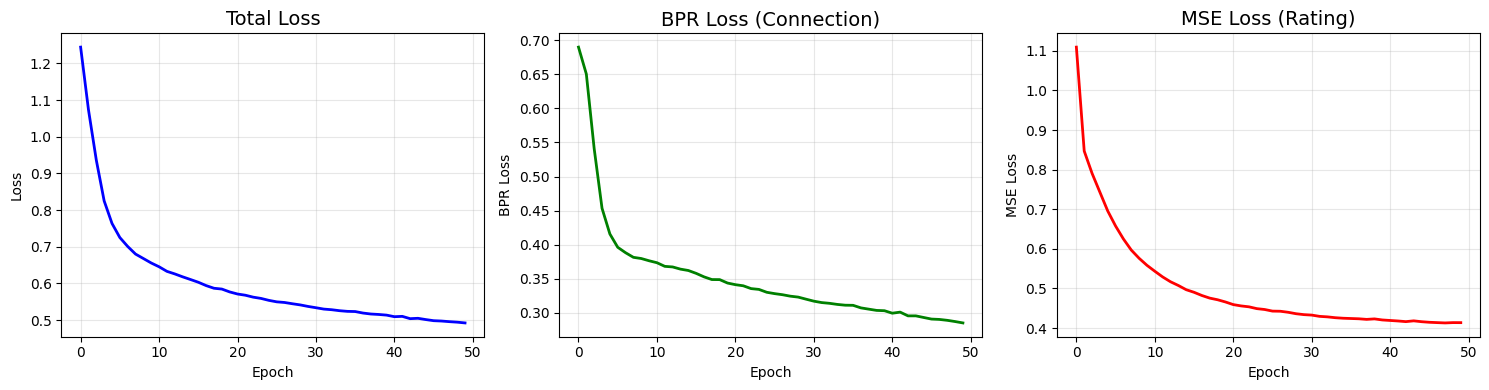

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['loss'], 'b-', linewidth=2)
axes[0].set_title('Total Loss', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(alpha=0.3)

axes[1].plot(history['bpr_loss'], 'g-', linewidth=2)
axes[1].set_title('BPR Loss (Connection)', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('BPR Loss')
axes[1].grid(alpha=0.3)

axes[2].plot(history['mse_loss'], 'r-', linewidth=2)
axes[2].set_title('MSE Loss (Rating)', fontsize=14)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('MSE Loss')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../cc_docs/ccc3_training.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Dual Prediction Function

In [12]:
# Prediction thresholds
CONN_THRESHOLD = 0.5
RATING_THRESHOLD = 4.0

print(f"Prediction thresholds:")
print(f"  Connection probability: {CONN_THRESHOLD}")
print(f"  Rating quality: {RATING_THRESHOLD}")

Prediction thresholds:
  Connection probability: 0.5
  Rating quality: 4.0


In [13]:
def predict_multi_task(test_input_df, conn_threshold=0.5, rating_threshold=4.0, 
                       strategy='both', verbose=True, show_details=False):
    """
    ★ CCC3: Multi-Task Prediction
    
    Uses both connection and rating predictions.
    
    Args:
        strategy: 'both' (AND), 'conn' (connection only), 'rating' (rating only)
    """
    model.eval()
    
    results = []
    stats = {'total_o': 0, 'total_items': 0}

    for _, row in test_input_df.iterrows():
        user = row['user']
        item = row['item']
        stats['total_items'] += 1
        
        if user not in user2idx or item not in item2idx:
            results.append({
                'user': user,
                'item': item,
                'recommend': 'X',
                'reason': 'unknown'
            })
            continue
        
        user_idx = user2idx[user]
        item_idx = item2idx[item]
        
        if item_idx in user_train_items[user_idx]:
            results.append({
                'user': user,
                'item': item,
                'recommend': 'X',
                'reason': 'in_train'
            })
            continue
        
        with torch.no_grad():
            u_t = torch.tensor([user_idx], dtype=torch.long).to(device)
            i_t = torch.tensor([item_idx], dtype=torch.long).to(device)
            
            conn_prob = model.predict_connection(u_t, i_t, edge_index, edge_weight).item()
            pred_rating = model.predict_rating(u_t, i_t, edge_index, edge_weight).item()
        
        # Decision based on strategy
        if strategy == 'both':
            recommend = 'O' if (conn_prob >= conn_threshold and pred_rating >= rating_threshold) else 'X'
        elif strategy == 'conn':
            recommend = 'O' if conn_prob >= conn_threshold else 'X'
        elif strategy == 'rating':
            recommend = 'O' if pred_rating >= rating_threshold else 'X'
        else:
            recommend = 'X'
        
        if recommend == 'O':
            stats['total_o'] += 1
        
        results.append({
            'user': user,
            'item': item,
            'recommend': recommend,
            'conn_prob': conn_prob,
            'pred_rating': pred_rating
        })

    results_df = pd.DataFrame(results)
    
    if verbose:
        print("=" * 80)
        if show_details:
            print(f"{'user':<8} {'item':<8} {'Conn_P':<8} {'Rating':<8} {'Rec':<4}")
            for _, r in results_df.iterrows():
                if 'conn_prob' in r:
                    print(f"{r['user']:<8} {r['item']:<8} {r['conn_prob']:<8.3f} {r['pred_rating']:<8.2f} {r['recommend']:<4}")
                else:
                    print(f"{r['user']:<8} {r['item']:<8} {'N/A':<8} {'N/A':<8} {r['recommend']:<4}")
        else:
            print(f"{'user':<10} {'item':<10} {'recommend':<10}")
            for _, r in results_df.iterrows():
                print(f"{r['user']:<10} {r['item']:<10} {r['recommend']:<10}")
        print("=" * 80)
        print(f"Total recommends = {stats['total_o']}/{stats['total_items']}")
        print(f"Not recommend = {stats['total_items'] - stats['total_o']}/{stats['total_items']}")
        print()

    return results_df


print("Multi-task prediction function ready!")

Multi-task prediction function ready!


## 10. Sample Prediction Test

In [14]:
# Load best model
model.load_state_dict(torch.load('../cc_models/ccc3_best.pt'))
model.eval()
print("Best model loaded")

Best model loaded


In [15]:
sample1 = pd.read_csv('../data/sample1.csv')

print("Sample1.csv Test (CCC3 - Multi-Task):")
print(f"Strategy: both (conn >= {CONN_THRESHOLD} AND rating >= {RATING_THRESHOLD})")
print()
predictions1 = predict_multi_task(sample1, CONN_THRESHOLD, RATING_THRESHOLD, 'both', verbose=True, show_details=True)

Sample1.csv Test (CCC3 - Multi-Task):
Strategy: both (conn >= 0.5 AND rating >= 4.0)

user     item     Conn_P   Rating   Rec 
109      3745     0.111    4.58     X   
88       4447     0.805    3.34     X   
71       4306     0.835    4.17     O   
66       1747     0.698    4.17     O   
15       66934    0.038    4.99     X   
Total recommends = 2/5
Not recommend = 3/5



In [16]:
sample2 = pd.read_csv('../data/sample2.csv')

print("Sample2.csv Test (CCC3 - Multi-Task):")
print(f"Strategy: both (conn >= {CONN_THRESHOLD} AND rating >= {RATING_THRESHOLD})")
print()
predictions2 = predict_multi_task(sample2, CONN_THRESHOLD, RATING_THRESHOLD, 'both', verbose=True, show_details=True)

Sample2.csv Test (CCC3 - Multi-Task):
Strategy: both (conn >= 0.5 AND rating >= 4.0)

user     item     Conn_P   Rating   Rec 
109.0    3745.0   0.111    4.58     X   
88.0     4447.0   0.805    3.34     X   
71.0     4306.0   0.835    4.17     O   
66.0     1747.0   0.698    4.17     O   
15.0     66934.0  0.038    4.99     X   
Total recommends = 2/5
Not recommend = 3/5



## 11. Evaluation

In [17]:
# Validation
val_test_df = val_df.copy()
val_test_df['user'] = val_test_df['user_idx'].map(idx2user)
val_test_df['item'] = val_test_df['item_idx'].map(idx2item)
val_test_df = val_test_df[['user', 'item']]

print(f"Evaluating on validation set: {len(val_test_df)} samples")

val_predictions = predict_multi_task(val_test_df, CONN_THRESHOLD, RATING_THRESHOLD, 'both', verbose=False)

val_labels = np.ones(len(val_predictions))
val_preds = (val_predictions['recommend'] == 'O').astype(int).values

val_acc = (val_preds == val_labels).mean()
val_prec = precision_score(val_labels, val_preds, zero_division=0)
val_rec = recall_score(val_labels, val_preds, zero_division=0)
val_f1 = f1_score(val_labels, val_preds, zero_division=0)

print(f"\nValidation Performance (CCC3 - Multi-Task):")
print(f"  Accuracy: {val_acc:.4f}")
print(f"  Precision: {val_prec:.4f}")
print(f"  Recall: {val_rec:.4f}")
print(f"  F1 Score: {val_f1:.4f}")

Evaluating on validation set: 7480 samples

Validation Performance (CCC3 - Multi-Task):
  Accuracy: 0.2552
  Precision: 1.0000
  Recall: 0.2552
  F1 Score: 0.4066


In [18]:
# Test
test_test_df = test_df.copy()
test_test_df['user'] = test_test_df['user_idx'].map(idx2user)
test_test_df['item'] = test_test_df['item_idx'].map(idx2item)
test_test_df = test_test_df[['user', 'item']]

print(f"Evaluating on test set: {len(test_test_df)} samples")

test_predictions = predict_multi_task(test_test_df, CONN_THRESHOLD, RATING_THRESHOLD, 'both', verbose=False)

test_labels = np.ones(len(test_predictions))
test_preds = (test_predictions['recommend'] == 'O').astype(int).values

test_acc = (test_preds == test_labels).mean()
test_prec = precision_score(test_labels, test_preds, zero_division=0)
test_rec = recall_score(test_labels, test_preds, zero_division=0)
test_f1 = f1_score(test_labels, test_preds, zero_division=0)

print(f"\nTest Performance (CCC3 - Multi-Task):")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  Precision: {test_prec:.4f}")
print(f"  Recall: {test_rec:.4f}")
print(f"  F1 Score: {test_f1:.4f}")

Evaluating on test set: 8365 samples

Test Performance (CCC3 - Multi-Task):
  Accuracy: 0.2629
  Precision: 1.0000
  Recall: 0.2629
  F1 Score: 0.4163


## 12. AUC-ROC Evaluation

In [19]:
print("Calculating AUC-ROC...")

val_pos_users = val_df['user_idx'].values
val_pos_items = val_df['item_idx'].values

val_test_edges = set()
for u, i in zip(val_df['user_idx'].values, val_df['item_idx'].values):
    val_test_edges.add((int(u), int(i)))
for u, i in zip(test_df['user_idx'].values, test_df['item_idx'].values):
    val_test_edges.add((int(u), int(i)))

n_neg = len(val_df)
neg_users, neg_items = [], []
attempts = 0
max_attempts = n_neg * 100

while len(neg_users) < n_neg and attempts < max_attempts:
    u = np.random.randint(0, n_users)
    i = np.random.randint(0, n_items)
    attempts += 1
    
    if i not in user_train_items[u] and (u, i) not in val_test_edges:
        neg_users.append(u)
        neg_items.append(i)

# Score using ensemble of both predictions
pos_scores = []
for u_idx, i_idx in zip(val_pos_users, val_pos_items):
    with torch.no_grad():
        u_t = torch.tensor([u_idx], dtype=torch.long).to(device)
        i_t = torch.tensor([i_idx], dtype=torch.long).to(device)
        
        conn_prob = model.predict_connection(u_t, i_t, edge_index, edge_weight).item()
        pred_rating = model.predict_rating(u_t, i_t, edge_index, edge_weight).item()
    
    # Combine scores
    combined_score = 0.5 * conn_prob + 0.5 * (pred_rating / 5.0)
    pos_scores.append(combined_score)

neg_scores = []
for u_idx, i_idx in zip(neg_users, neg_items):
    with torch.no_grad():
        u_t = torch.tensor([u_idx], dtype=torch.long).to(device)
        i_t = torch.tensor([i_idx], dtype=torch.long).to(device)
        
        conn_prob = model.predict_connection(u_t, i_t, edge_index, edge_weight).item()
        pred_rating = model.predict_rating(u_t, i_t, edge_index, edge_weight).item()
    
    combined_score = 0.5 * conn_prob + 0.5 * (pred_rating / 5.0)
    neg_scores.append(combined_score)

all_scores = np.concatenate([pos_scores, neg_scores])
all_labels = np.concatenate([np.ones(len(pos_scores)), np.zeros(len(neg_scores))])

val_auc = roc_auc_score(all_labels, all_scores)

print(f"\nValidation AUC-ROC: {val_auc:.4f}")
print(f"  Positive scores: mean={np.mean(pos_scores):.4f}")
print(f"  Negative scores: mean={np.mean(neg_scores):.4f}")

Calculating AUC-ROC...

Validation AUC-ROC: 0.8507
  Positive scores: mean=0.6456
  Negative scores: mean=0.2826


## 13. Final Summary

In [20]:
print("="*70)
print("CCC3 - Combined Collaborative Approach (Multi-Task Learning)")
print("="*70)

print(f"\nArchitecture:")
print(f"  Shared LightGCN backbone")
print(f"  Connection Head: {sum(p.numel() for p in model.connection_head.parameters()):,} params")
print(f"  Rating Head: {sum(p.numel() for p in model.rating_head.parameters()):,} params")
print(f"  Total: {sum(p.numel() for p in model.parameters()):,} params")

print(f"\nTraining:")
print(f"  Loss: λ_conn * BPR + λ_rating * MSE")
print(f"  λ_conn: {LAMBDA_CONN}")
print(f"  λ_rating: {LAMBDA_RATING}")
print(f"  Best training loss: {best_loss:.4f}")

print(f"\nValidation Performance:")
print(f"  AUC-ROC: {val_auc:.4f}")
print(f"  Precision: {val_prec:.4f}")
print(f"  Recall: {val_rec:.4f}")
print(f"  F1 Score: {val_f1:.4f}")

print(f"\nTest Performance:")
print(f"  Precision: {test_prec:.4f}")
print(f"  Recall: {test_rec:.4f}")
print(f"  F1 Score: {test_f1:.4f}")

print(f"\nModel saved to: ../cc_models/ccc3_best.pt")
print(f"Ready for final comparison with all models!")

CCC3 - Combined Collaborative Approach (Multi-Task Learning)

Architecture:
  Shared LightGCN backbone
  Connection Head: 545 params
  Rating Head: 1,089 params
  Total: 353,282 params

Training:
  Loss: λ_conn * BPR + λ_rating * MSE
  λ_conn: 1.0
  λ_rating: 0.5
  Best training loss: 0.4923

Validation Performance:
  AUC-ROC: 0.8507
  Precision: 1.0000
  Recall: 0.2552
  F1 Score: 0.4066

Test Performance:
  Precision: 1.0000
  Recall: 0.2629
  F1 Score: 0.4163

Model saved to: ../cc_models/ccc3_best.pt
Ready for final comparison with all models!
